In [3]:
import graph_tool.all as gt
import plotly.graph_objects as go
import cloudpickle as pickle
import pandas as pd
import numpy as np
import sys
sys.path.append("../hSBM_Topicmodel/")
sys.path.append("../trisbm/")
from topicpy.hsbmpy import get_scores, get_scores_shuffled, normalise_score

Creating directory /home/jovyan/.config/bioservices 


In [6]:
experiments = ["APS", "Wikipedia", "Twitter", "Plos", "BRCA", "TCGA"]
stores = ["aps", "wikipedia", "twitter", "plos", "tcga", "tcga"]
eval_labels = [["journal"], ["Topic"], ["kind"], ["journal"], ["Subtype_Selected"], ["cases.0.project.primary_site"]]

In [8]:
all_scores = {}

for experiment, store, labels in zip(experiments, stores, eval_labels):
    scores = get_scores(f"{experiment}/{store}_key", labels, algorithm="trisbm", verbose=False)
    scores['trisbm'] = scores[labels[0]]
    scores["hsbm"]=get_scores(f"{experiment}/{store}", labels, algorithm="topsbm", verbose=False)[labels[0]]
    scores['shuffle'] = get_scores_shuffled(f"{experiment}/{store}", pd.read_csv(f"{experiment}/{store}/files.dat", sep=",", index_col=0), label=labels[0], algorithm='topsbm')
    normalise_score(scores, base_algorithm="shuffle", operation=lambda x,y: x/y)
    
    all_scores[experiment]=scores

In [9]:
all_scores[experiment].keys()

dict_keys(['cases.0.project.primary_site', 'trisbm', 'hsbm', 'shuffle'])

In [26]:
def get_score_area(score, experiment, metric="V"):
    x = np.log10(10+np.array(score[experiment]["xl"]))
    y = np.array(score[experiment][metric])
    ix = np.argsort(x)
    return np.trapz(np.log10(x[ix]),y[ix])

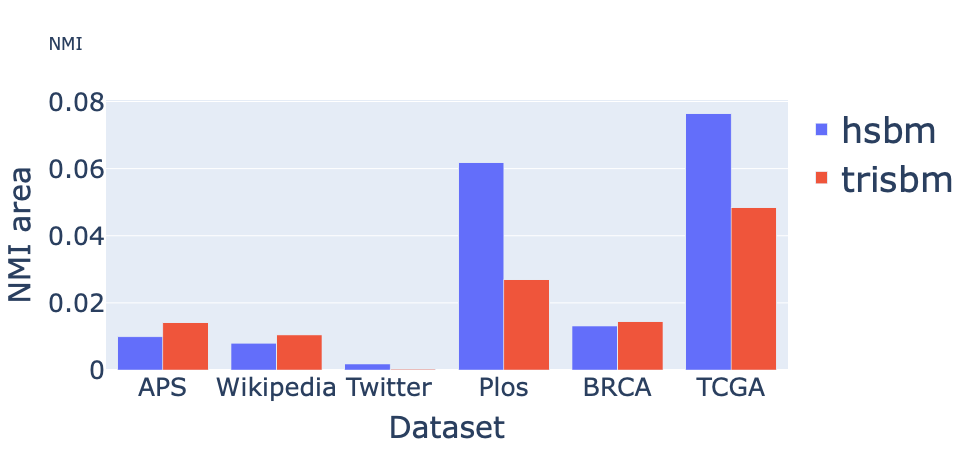

In [27]:
fig = go.Figure()

sbmtm_scores = np.array([get_score_area(all_scores[experiment],"hsbm") for experiment in all_scores.keys()])
trisbm_scores = np.array([get_score_area(all_scores[experiment],"trisbm") for experiment in all_scores.keys()])

fig.add_traces([
    go.Bar(y=sbmtm_scores, name="hsbm"),
    go.Bar(y=trisbm_scores, name = "trisbm")
])

titlefont = {
    "size": 30 
}

tickfont = {
    "size":25
}

layout = {
    "title":"NMI",
    "xaxis":{
        "title": "Dataset",
        "tickmode": "array",
        "tickvals": list(range(len(experiments))),
        "ticktext": experiments,
        "titlefont": titlefont,
        "tickfont": tickfont
    },
    "yaxis":{
        "title": "NMI area",
        "titlefont": titlefont,
        "tickfont": tickfont,
    },
    "legend":{
        "font_size":35
    }
}

fig.update_layout(layout)

fig.show()
fig.write_image("NMI_comparison.pdf", engine="kaleido")

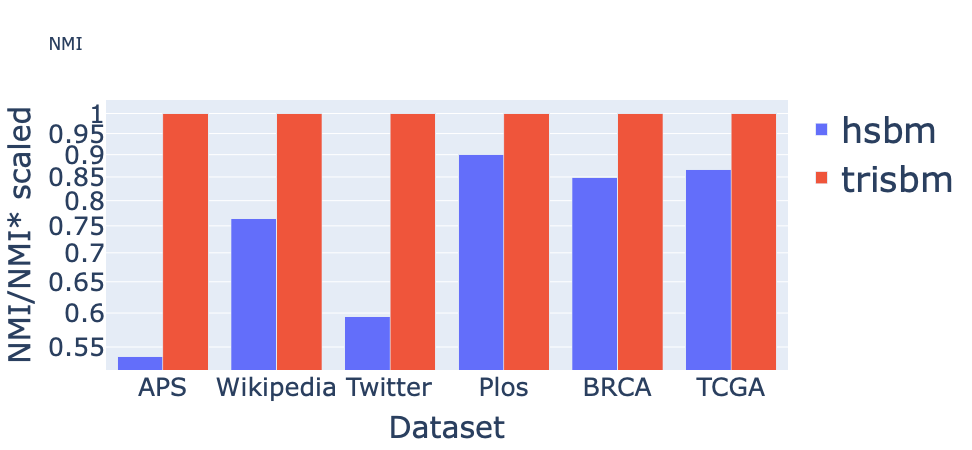

In [12]:
fig = go.Figure()

sbmtm_scores = np.array([max(all_scores[experiment]["hsbm"]["norm_V"]) for experiment in all_scores.keys()])
trisbm_scores = np.array([max(all_scores[experiment]["trisbm"]["norm_V"]) for experiment in all_scores.keys()])

fig.add_traces([
    go.Bar(y=sbmtm_scores/trisbm_scores, name="hsbm"),
    go.Bar(y=trisbm_scores/trisbm_scores, name = "trisbm")
])

titlefont = {
    "size": 30 
}

tickfont = {
    "size":25
}

layout = {
    "title":"NMI",
    "xaxis":{
        "title": "Dataset",
        "tickmode": "array",
        "tickvals": list(range(len(experiments))),
        "ticktext": experiments,
        "titlefont": titlefont,
        "tickfont": tickfont
    },
    "yaxis":{
        "type":"log",
        "title": "NMI/NMI* scaled",
        "titlefont": titlefont,
        "tickfont": tickfont,
    },
    "legend":{
        "font_size":35
    }
}

fig.update_layout(layout)

fig.show()
fig.write_image("NMIscaled_comparison.pdf", engine="kaleido")

In [13]:
sbmtm_entropies = []
trisbm_entropies = []


for experiment in experiments:
    with open(f"{experiment}/sbmtm.pkl", "rb") as file:
        model = pickle.load(file)
        
    sbmtm_entropies.append(model.get_mdl())
        
    with open(f"{experiment}/trisbm.pkl", "rb") as file:
        model = pickle.load(file)
        
    trisbm_entropies.append(model.state.entropy())

In [14]:
delta_Sigma = (np.array(trisbm_entropies) - np.array(sbmtm_entropies))*np.log10(np.exp(1))

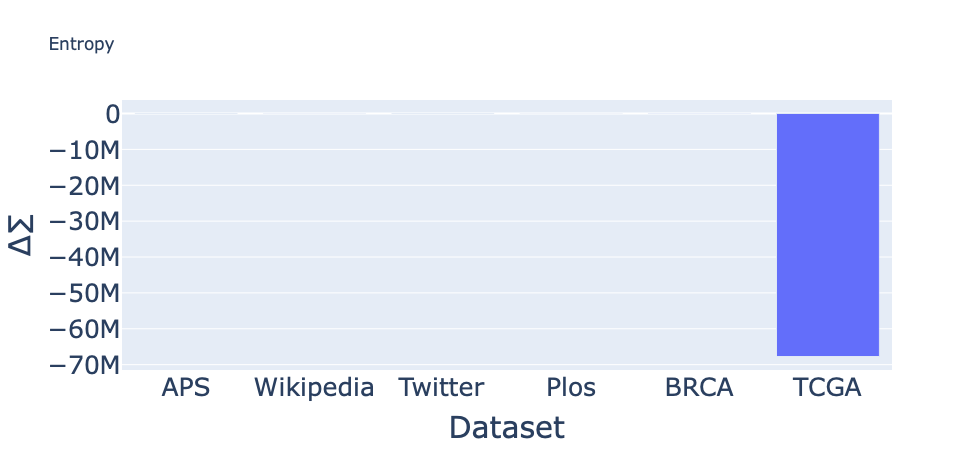

In [18]:
fig = go.Figure()

        
fig.add_traces([
    go.Bar(y=delta_Sigma, name="hsbm"),
])

titlefont = {
    "size": 30 
}

tickfont = {
    "size":25
}

layout = {
    "title":"Entropy",
    "xaxis":{
        "title": "Dataset",
        "tickmode": "array",
        "tickvals": list(range(len(experiments))),
        "ticktext": experiments,
        "titlefont": titlefont,
        "tickfont": tickfont
    },
    "yaxis":{
        "title": "Δ∑",
        #"type":"log",
        "titlefont": titlefont,
        "tickfont": tickfont,
    },
    "legend":{
        "font_size":35
    }
}

fig.update_layout(layout)

fig.show()
fig.write_image("entropy_comparison.pdf", engine="kaleido")